In [1]:
import pandas as pd
from tqdm import tqdm
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

from predictor import generate_confusion_matrix

# Model evaluation on test data

In [2]:
info_dict = {}

for fingerprint, model in tqdm(
    list(
        product(
            ["ecfp4", "rdkit", "maccs", "chem_phys", "mhfp6", "erg"], ["rf", "xgboost"]
        )
    )
):
    report_df, confusion_matrix, fpr_list, tpr_list, matrix_labels = (
        generate_confusion_matrix(fingerprint_name=fingerprint, model_name=model)
    )
    info_dict[fingerprint + "_" + model] = {
        "report": report_df,
        "confusion_matrix": confusion_matrix,
        "fpr_list": fpr_list,
        "tpr_list": tpr_list,
        "confusion_matrix_labels": matrix_labels,
    }

100%|██████████| 12/12 [00:21<00:00,  1.78s/it]


In [3]:
metric_df = pd.concat([data_dict["report"] for _, data_dict in info_dict.items()])
metric_df.sort_values(
    by=["cohen_kappa", "roc_auc"], ascending=[False, False], inplace=True
)
metric_df

,accuracy,cohen_kappa,macro_precision,macro_recall,macro_f1,roc_auc
mhfp6_rf,0.835725,0.757016,0.841158,0.824831,0.831805,0.880668
ecfp4_rf,0.827640,0.745460,0.830429,0.817897,0.823333,0.875808
rdkit_rf,0.822182,0.737621,0.827329,0.813867,0.820241,0.872778
rdkit_xgboost,0.817735,0.731634,0.819126,0.810307,0.814521,0.870444
maccs_rf,0.815781,0.730405,0.810141,0.812011,0.810941,0.871741
mhfp6_xgboost,0.797925,0.707518,0.780923,0.801448,0.787936,0.864643
erg_rf,0.799407,0.705233,0.793462,0.789882,0.791455,0.857340
ecfp4_xgboost,0.790176,0.693650,0.772032,0.782202,0.775342,0.852725
erg_xgboost,0.772253,0.667820,0.754765,0.762631,0.757123,0.839839
chem_phys_rf,0.755003,0.643022,0.731404,0.742195,0.736222,0.826747


# AUC-ROC Comparison across fingerprints

In [4]:
labels = []
fpr_list = []
tpr_list = []

for fingerprint, info in info_dict.items():
    if "rf" not in fingerprint:
        continue

    if len(fingerprint.split("_")) > 2:
        fingerprint = fingerprint.replace("_", "", 1)

    fingerprint = fingerprint.split("_")[0]

    if fingerprint == "chemphys":
        fingerprint = "ChemPhys"
    elif fingerprint == "erg":
        fingerprint = "ErG"
    else:
        fingerprint = fingerprint.upper()

    labels.append(fingerprint)
    fpr_list.append(info["fpr_list"])
    tpr_list.append(info["tpr_list"])

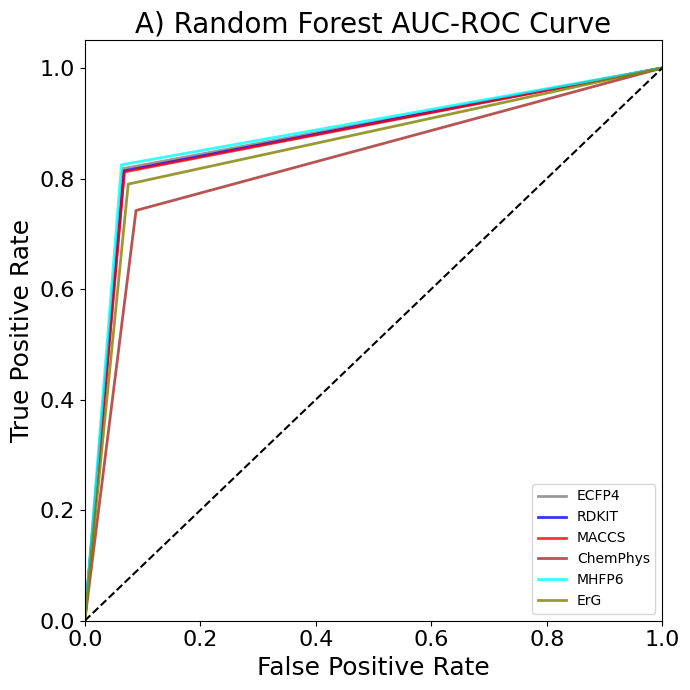

In [5]:
plt.figure(figsize=(7, 7))

colors = {
    "ECFP4": "gray",
    "MHFP6": "cyan",
    "ChemPhys": "brown",
    "ErG": "olive",
    "MACCS": "red",
    "RDKIT": "blue",
}

for i in range(len(fpr_list)):
    c = colors[labels[i].split("_")[0]]

    sns.lineplot(
        x=fpr_list[i],
        y=tpr_list[i],
        markers=True,
        markersize=10,
        dashes=True,
        linewidth=2,
        alpha=0.8,
        label=labels[i],
        color=c,
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("A) Random Forest AUC-ROC Curve", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("../figures/figure_6a", dpi=400)
plt.show()

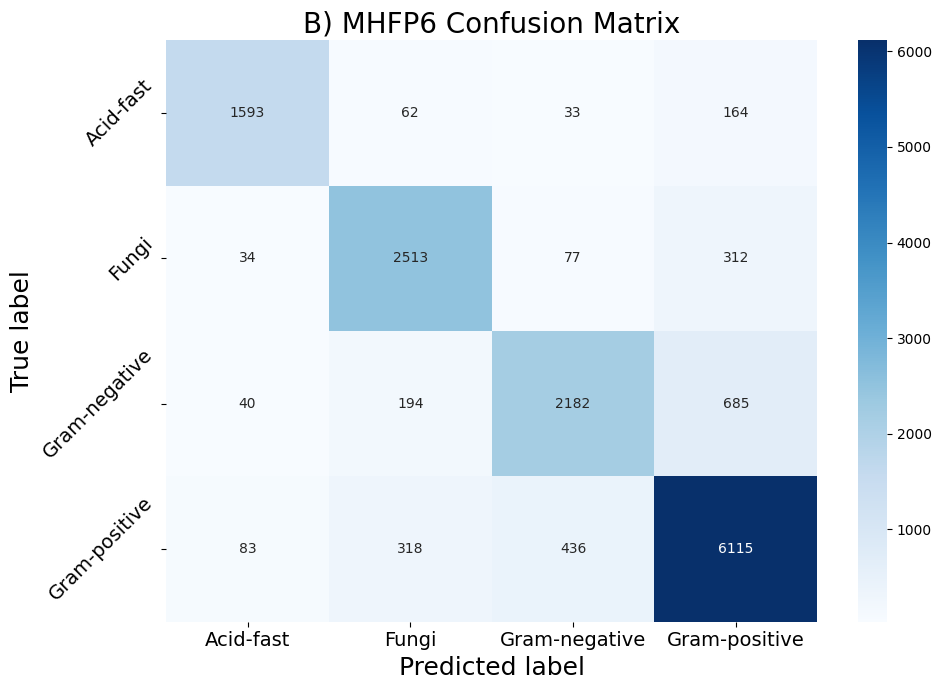

In [6]:
plt.figure(figsize=(10, 7))

# Confusion matrix for best model
cm = info_dict[metric_df.index[0]]["confusion_matrix"]
label_classes = info_dict[metric_df.index[0]]["confusion_matrix_labels"]
fingerprint_name = metric_df.index[0].split("_", maxsplit=1)[0]

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    yticklabels=[i.capitalize() for i in label_classes],
    xticklabels=[i.capitalize() for i in label_classes],
)
plt.xlabel("Predicted label", fontsize=18)
plt.ylabel("True label", fontsize=18)
plt.title(f"B) {fingerprint_name.upper()} Confusion Matrix", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=45)

plt.tight_layout()
plt.savefig("../figures/figure_6b.png", dpi=400)
plt.show()